# Project 3 – Polynomial Interpolation
## MATH 3316 High Performance Scientific Computing, Fall 2016

Author: Paul Herz

The designated programming language for this project was C++, built in Xcode and compiled with Clang (Apple LLVM 8.0.0) using the C++14 dialect.

### Structure of this Project

This project's file structure follows the GNU-style C++ project standard.

In [1]:
%ls ..

HPSCProject3.xcodeproj/ data/                   reports/
Makefile                lib/                    src/
bin/                    notebooks/


Excluding the `.xcodeproj` file, which was used for integration with the Xcode IDE, debugging, and profiling purposes, each item in the project directory serves the following purpose:

- `Makefile`: GNU Make project build automation definitions
- `bin/`: compiled binaries. Make will put binaries here by default.
- `data/`: where calculated data is stored after program execution. Files are `.txt` files containing real numbers, space delimited to denote row items, and newline delimited to denote new rows. Some data files, whose names end in `_out`, are just piped output from program execution and follow no specific format.
- `lib/`: reused libraries that are not part of this project specifically. Contains my rewrite of the Matrix library ([phrz/matrix](https://github.com/phrz/matrix)).
- `notebooks/`: Python 3 Jupyter notebooks, notably the one used to generate this report.
- `reports/`: PDFs generated from the Jupyter notebooks via `nbconvert` and `pdflatex`.
- `src/`: contains the main mathematical routines described in this report, which are used to generate the data and redirected output in `data/`.

### Using this Project

#### Prerequisites
- A Unix or Unix-like OS (e.g. macOS or Linux)
- A compiler with support for C++14 (LLVM or GNU toolchain)
- Python ≥3.5
- The latest Jupyter distribution
- LaTeX with `pdflatex`
- GNU Make ≥3.81

#### Building this project
This project provides several GNU Make targets, with a handful of them being especially useful.

`make all` (default) - will compile binaries, execute them to generate data files, execute Jupyter notebooks under fresh kernels with just-generated data files, and convert them to PDFs in `/reports`.

`make all_bin` - will compile binaries for parts A, B, and C (`vandermonde`, `newton`, and `kepler`) of this project.

`make all_data` - will compile binaries and execute them to generate data files.

`make clean` - will delete all compiled binaries, generated data, executed notebook copies (but not the original notebooks), and **report PDFs**.

Below, find attached the full Makefile:

In [2]:
%cat ../Makefile

#
#  Makefile
#  HPSCProject3
#
#  Created by Paul Herz on 11/2/16.
#  Copyright © 2016 Paul Herz. All rights reserved.
#

TARGETA = newtonform
TARGETB = lagrange2d
TARGETC = runge_uniform
TARGETD = runge_chebyshev

CXX = g++
CFLAGS = -std=c++14

SRC = src/
LIB = lib/
BIN = bin/
ROOT = $(shell pwd)/
DATA = data/
NB = notebooks/
RP = reports/

AFILES = test_NewtonForm.cpp
BFILES = test_Lagrange2D.cpp
CFILES = runge_uniform.cpp
DFILES = runge_Chebyshev.cpp
LIBFILES = Vector.cpp Matrix.cpp

NOTEBOOKAB = $(NB)proj3.ipynb
NOTEBOOKCD = $(NB)Runge2D.ipynb
REPORTAB = $(RP)proj3.pdf
REPORTCD = $(RP)Runge2D.pdf



################################
# All target                   #
################################

all: all_bin all_data all_reports



################################
# Application binaries         #
################################

all_bin: $(TARGETA) $(TARGETB) $(TARGETC) $(TARGETD)

$(TARGETA):
	$(CXX) $(CFLAGS) -o $(BIN)$(TARGETA) -I $(LIB) $(addprefix $(LIB), $(LIBFILES)) $(ad

## Part A – Newton Interpolation

Part A focuses on the calculation and construction of an interpolating polynomial in Newton form, and consequential error analysis against the source ("true") function.

### Goals

### Math Background

#### Newton Interpolating Polynomial Recursive Step

Given $k$ sample points $(x_i,y_i)$ of the true function $y=f(x)$ of degree $n+1$, we wish to calculate the interpolating polynomial of degree $n$, $p_j(x)$, with coefficients $a_0\ldots a_{n-1}$ The calculation of a Newton interpolating polynomial begins a given value for the first polynomial term (the linear term), $a_0=y_0$. Following that, calculation of $a_i$ for $i=1\ldots n$ is given by the recursive step:

$$
a_{i+1} = \frac{y_{i+1}-p_i(x_{n+1})}{(x_{i+1}-x_0)(x_{i+1}-x_1)\ldots(x_{i+1}-x_i)}
$$

### Implementation Requirements

#### Newton Form Implementation

I was required to write functions in C++ which implemented the Newton interpolation process (described above) in several steps, described by mandatory functions `Newton_basis`, `Newton_nestedform`, and `Newton_coefficients`. `Newton_basis` evaluates the basis function $\Phi_{n+1}(x)$, which you can see above as the denominator of the recursive step, i.e.: 
$$\prod_{n=0}^{j}(x_{i+1}-x_j)$$

`Newton_nestedform` evaluates the resultant Newton form of the interpolating polynomial given the calculated coefficients $a$ and the requested $x$-nodes using Horner's method for efficiency:
$$p_n(x) = a_0 + (x-x_0)( a_1 + (x-x_1) ( \ldots a_n + (x-x_n)(a_{n+1}) \ldots ))$$

`Newton_coefficients` implements the above-described recursive step in an iterative form (for clarity and efficiency), up to the necessary formal degree `n` given a set of nodes $(x_i,y_i)$ of size `n+1`. 

#### Newton Testing

I was required to create a file `test_NewtonForm.cpp`, which (as expected) tested a function $f(x)$:
$$
f(x) = 3.1x^4 + 2.3x^3 - 6.6x^2 + 8.7x + 7.9
$$
With known points (nodes) $(x_i,y_i), i\in\mathbb{Z} : 0 \leq i \leq 4$ where $x_i=\{-2,-1,0,1,2\}$.
The test of the algorithm was to generate a fourth-degree Newton form interpolating polynomial $p_4(x)$.
For presentational purposes, I needed to evaluate $f(x)$ and $p_4(x)$ over the same 201-point linear span $[-3,3]$,
and then plot the error of $p_4(x)$ in interpolating the true function.

### Implementation

#### Newton Form Implementation

In [3]:
%cat ../src/Newtonform.cpp

//
//  NewtonForm.cpp
//  HPSCProject3
//
//  Created by Paul Herz on 10/18/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#ifndef _s
#define _s std::to_string
#endif

#include <iostream>
#include "Matrix.h"
#include "Vector.h"
#include "println.cpp"

using namespace PH;

double Newton_basis(const Vector& xnodes, size_t n, double x) {
	// Evaluate the Newton basis function ɸ_n+1(x) defined as:
	//     ɸ_n+1(x) = (x - x_0)(x - x_1) ... (x - x_n)
	double result = 1.0;
	
	for(int i = 0; i < n; i++) {
		result *= x - xnodes[i];
	}
	
	return result;
}

double Newton_nestedform(const Vector& a, const Vector& xnodes, double x) {
	// Evaluate the Newton form p_n(x) defined as:
	//     p_n(x) = a_0 + a_1(x-x_0) + a_2(x-x_0)(x-x_1) + ...
	//              ... + a_n+1(x-x_0)...(x-x_n)
	// using nested multiplication:
	//     p_n(x) = a_0 + (x-x_0)( a_1 + (x-x_1) ( ... a_n + (x-x_n)(a_n+1) ... ))
	
	#if _PH_VERBOSE
		println("\n\nNested form");
		println("x:", x);
		println("x_i:", xn

#### Newton Testing

In [4]:
%cat ../src/test_Newtonform.cpp

//
//  test_NewtonForm.cpp
//  HPSCProject3
//
//  Created by Paul Herz on 10/18/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#define _PH_VERBOSE true

#include <iostream>
#include <cmath>
#include <string>

#include "Vector.h"
#include "NewtonForm.cpp"
#include "println.cpp"

using namespace PH;

double evaluatePolynomial(const Vector& a, double x) {
	size_t n = a.size() - 1; // zero indexing
	double result = a[n];
	for(size_t i = n-1; i < n; --i) {
		result = std::fma(result, x, a[i]); // (result * x) + a_i
	}
	
	return result;
}

int main(int argc, const char * argv[]) {
	
	auto f = [](const double x) -> double {
		return (3.1 * std::pow(x,4) + 2.3 * std::pow(x,3) - 6.6 * std::pow(x,2)
			  + 8.7 * x + 7.9);
	};
	
	// x nodes are -2, -1, 0, 1, 2
	auto xnodes = Vector({-2, -1, 0, 1, 2});
	
	// y nodes are f(x nodes)
	auto ynodes = xnodes;
	ynodes.mapElements([&](double& e, size_t i) {
		e = f(e);
	});
	
	// 1. Build a fourth-degree Newton polynomial p_4(x)
	auto p4 = 

A verbose mode was included in the code for debugging, which accounts for some of the length of the above code.

### Graphs

In [5]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({
        'font.family': 'Helvetica, Arial, sans-serif'
})

%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [6]:
names = ['newton_error_y','newton_y','true_y']
v = {}
for name in names:
    v[name] = loadtxt('../data/a/' + name + '.txt')
v['x'] = linspace(-3,3,201)

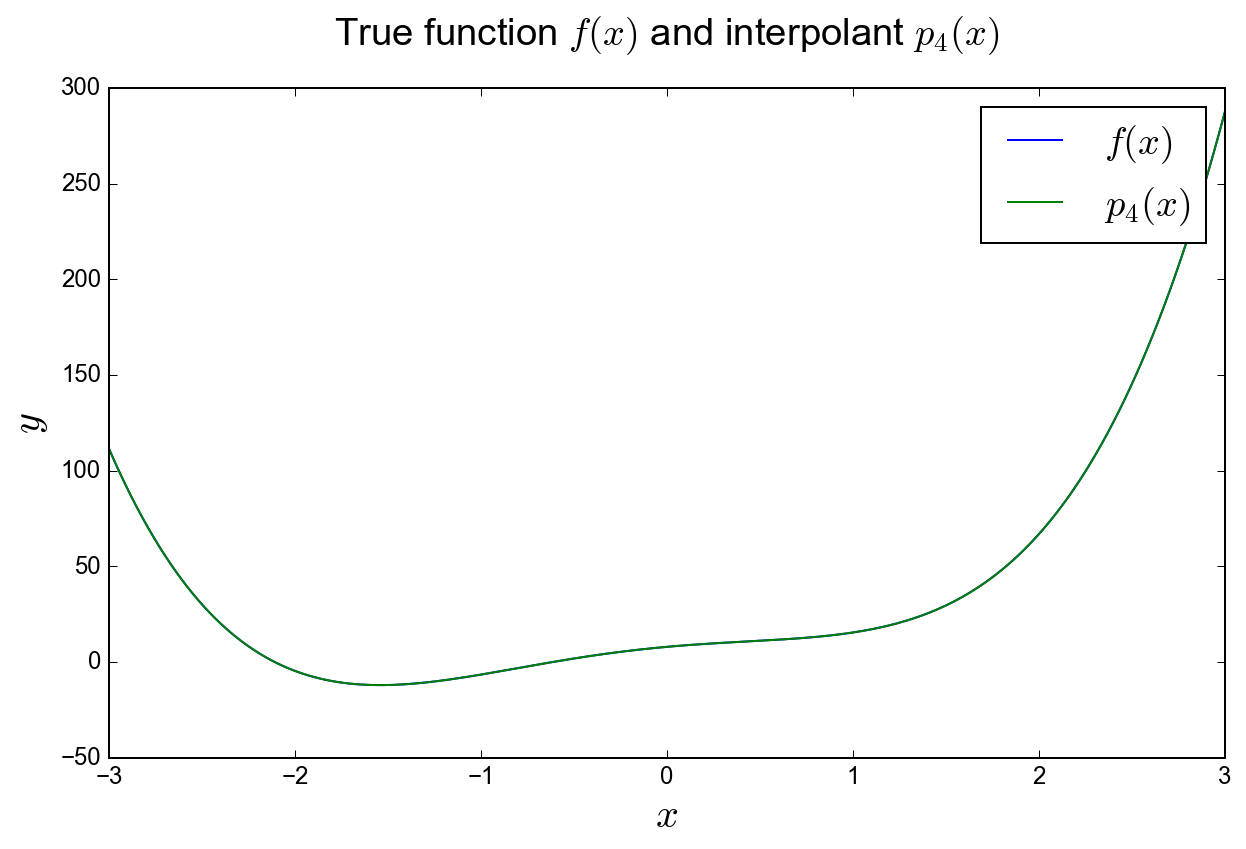

In [8]:
# Comparatively plot the true function and the interpolating polynomial in Newton form.

pylab.plot(v['x'], v['true_y'])
pylab.plot(v['x'], v['newton_y'])

pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.title('True function $f(x)$ and interpolant $p_4(x)$', y=1.05)
pylab.legend(('$f(x)$','$p_4(x)$'), loc=1)

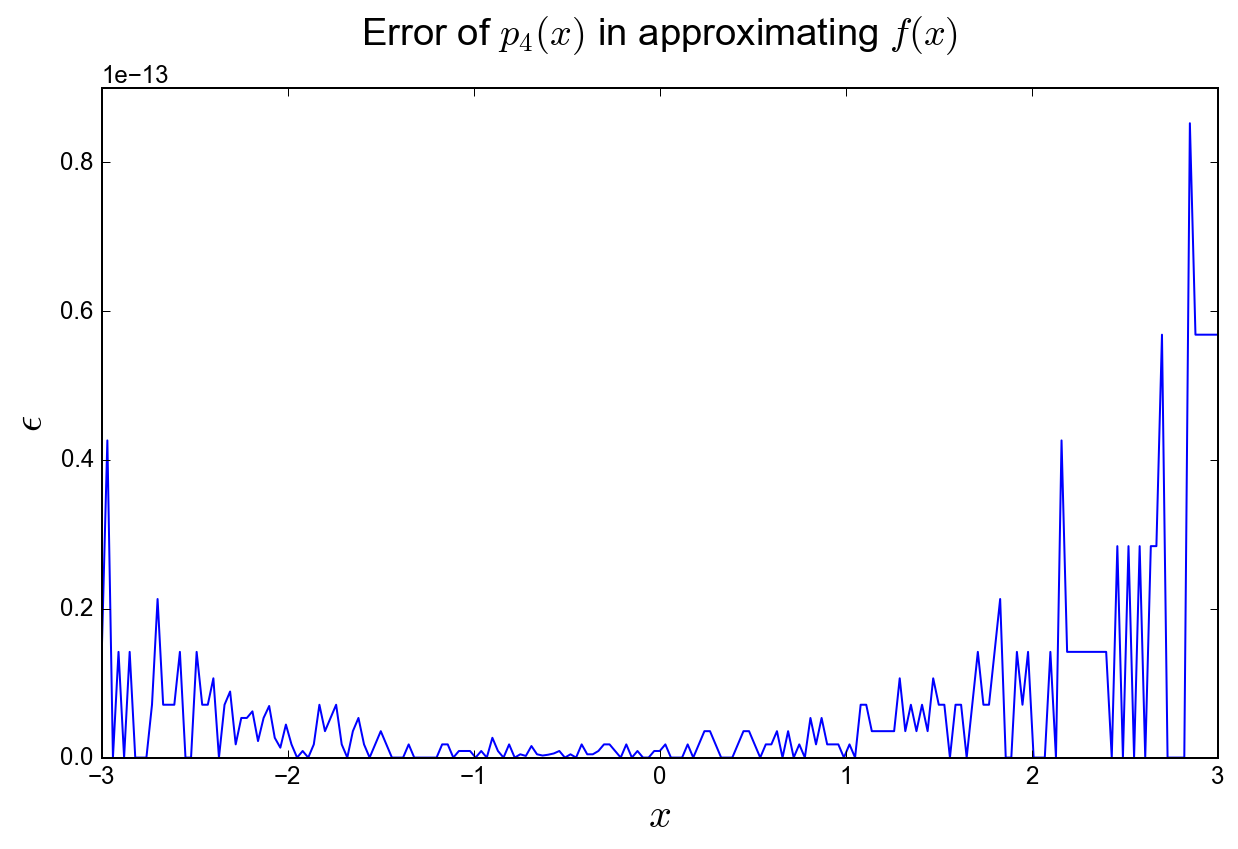

In [17]:
pylab.plot(v['x'], v['newton_error_y'])

pylab.xlabel('$x$')
pylab.ylabel('$\epsilon$')
pylab.title('Error of $p_4(x)$ in approximating $f(x)$', y=1.05)

### Analysis

For a least possible degree $n$, there exists only one polynomial capable of passing through a given finite set of points. The true function in the above test $f(x)$ is of the fourth degree, and I generate a fourth-degree interpolating polynomial $p_4(x)$. The fact that it is in Newton form does not mean much, it is merely another way of representing the same singular polynomial. Thus, in theory, and barring computational or design error, the true function and interpolating polynomial graphs should follow exactly.

Originally, due to a misunderstanding of how Newton's form polynomials are evaluated, there was significant error, which compelled me to reevaluate my code, thus resolving the issue.

After working to fix this issue, which was purely a mathematical error, the graphs did come to verify my above expectation.

Error was insignificant and mostly resulted from calculational (computational) error, but did increase at either end of the plotting domain $[-3,3]$. This is potentially due larger calculational error for larger numbers, i.e. not a relative increase in error. When the error data is normalized (divided by $x$ except at $x=0$), the error looks much flatter, lending some credibility to this hypothesis.

## Part B – Multidimensional Interpolation


### Goals

I needed to use a provided Lagrange interpolation algorithm and implement a two-dimensional extension of this.

### Math Background

#### 2D Lagrange interpolant
$$
p(a,b) = \sum_{i=0}^{m} \sum_{j=0}^{n} f(x_i,y_j) l_{i,j}(a,b)
$$

### Implementation

#### 2D Lagrange

I had to implement a function `Lagrange2D` which, given a two dimensional mesh consisting of an `x` and `y` matrix, as well as a value matrix `f` ($f(x,y)$), and a point at which to evaluate the interpolant $(a,b)$. Implementation using the preexisting `Lagrange` code was trivial:

In [18]:
%cat ../src/Lagrange2D.cpp

//
//  Lagrange2D.cpp
//  HPSCProject3
//
//  Created by Paul Herz on 10/25/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#include <iostream>

#include "Matrix.h"
#include "Vector.h"
#include "Lagrange.cpp"

using namespace PH;

double Lagrange2D(const Vector& x, const Vector& y, const Matrix& f, double a, double b) {
	
	double sum = 0.0;
	f.forEach([&](const double& e, size_t i, size_t j) {
		sum += e * Lagrange_basis(x, i, a) * Lagrange_basis(y, j, b);
	});
	
	return sum;
}


#### 2D Lagrange Testing

Testing was also trivial, involving at first 11 nodes and then 21 nodes in each dimensional direction. Most code was setup of the evaluation linear span $(a_i,b_i)$, the mesh span $(x,y)$, and the values matrix $z$. Testing code was based off of a modified version of Daniel Reynold's Lagrange test code provided to me as part of the project.

In [20]:
%cat ../src/test_Lagrange2D.cpp

/* Daniel R. Reynolds
   SMU Mathematics
   Math 3316
   1 October 2015 */

// Inclusions
#include <iostream>
#include <cmath>
#include <string>

#include "Matrix.h"
#include "Lagrange2D.cpp"

using namespace PH;

// This routine tests the function lagrange2D.cpp.
int main(int argc, char* argv[]) {

	// create Lambda function for f(x,y)
	auto f = [](const double x, const double y) -> double { 
		return (std::sinh(2.0*x) * std::cos(3.0*y));
	};
	
	// set evaluation points (a,b) in a mesh over the domain
	auto a = Vector::linSpace(-2.0, 2.0, 75);
	auto b = Vector::linSpace(-2.0, 2.0, 75);
	
	// *************************************
	// TEST ONE - 11 nodes in each direction
	// *************************************
	int m = 10;
	int n = 10;
	
	auto x = Vector::linSpace(-2.0, 2.0, m+1);
	auto y = Vector::linSpace(-2.0, 2.0, n+1);
	
	// z - the known points input to the Lagrange function
	Matrix z(m+1,n+1);
	z.mapElements([&](double& e, size_t r, size_t c){
		e = f(x[r], y[c]);
	});

	// p 

### Graphs

In [21]:
prefix = '../data/b/'
a = loadtxt(prefix+'a.txt')
b = loadtxt(prefix+'b.txt')
f = loadtxt(prefix+'ftrue.txt')
p10 = loadtxt(prefix+'p10.txt')
p20 = loadtxt(prefix+'p20.txt')

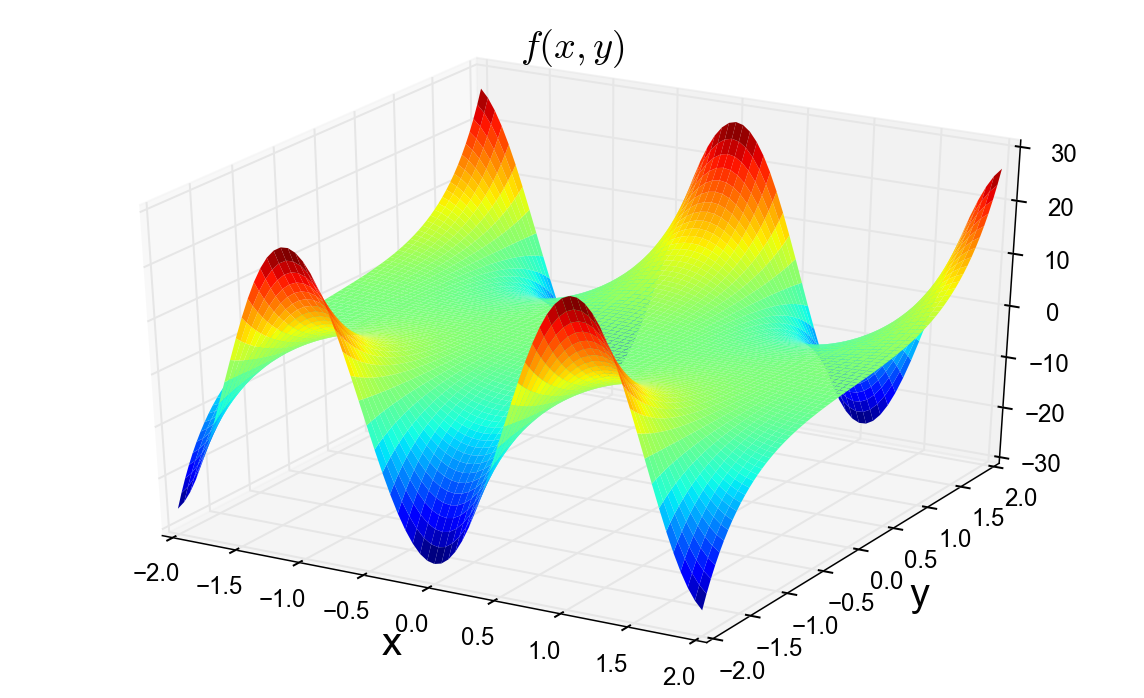

In [22]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = meshgrid(b, a)
surf = ax.plot_surface(X, Y, f, rstride=1, cstride=1, linewidth=0, cmap=cm.jet)
ax.set_xlabel('x')
ax.set_ylabel('y')
title('$f(x,y)$')

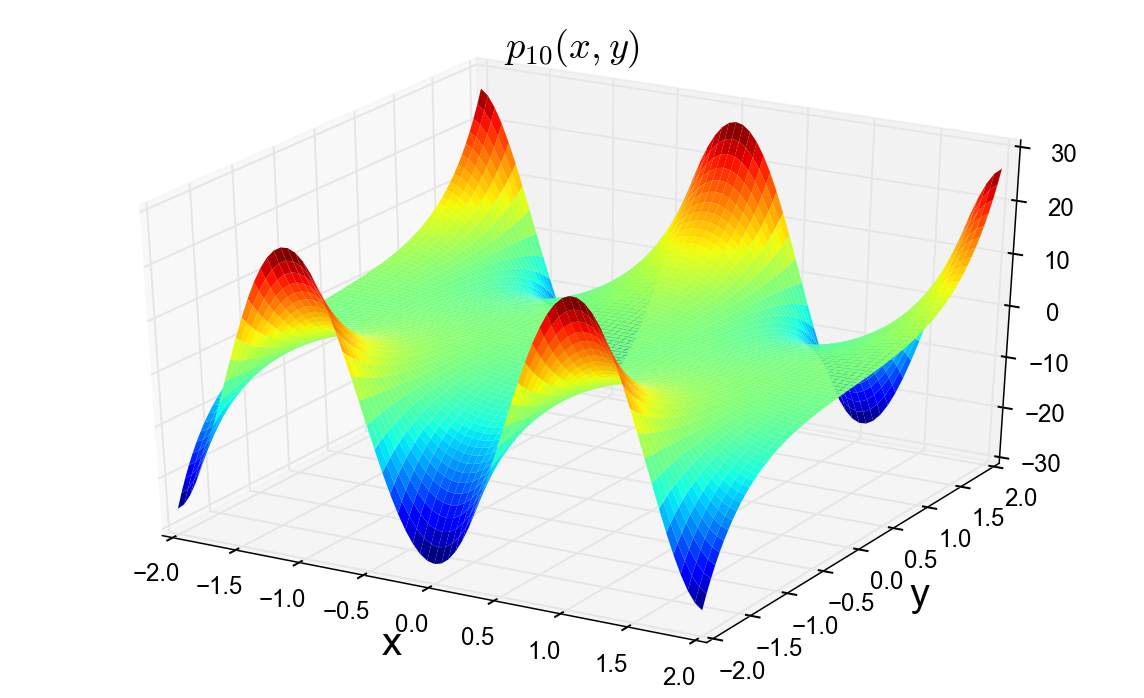

In [23]:
fig = figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, p10, rstride=1, cstride=1, linewidth=0, cmap=cm.jet)
ax.set_xlabel('x')
ax.set_ylabel('y')
title('$p_{10}(x,y)$')

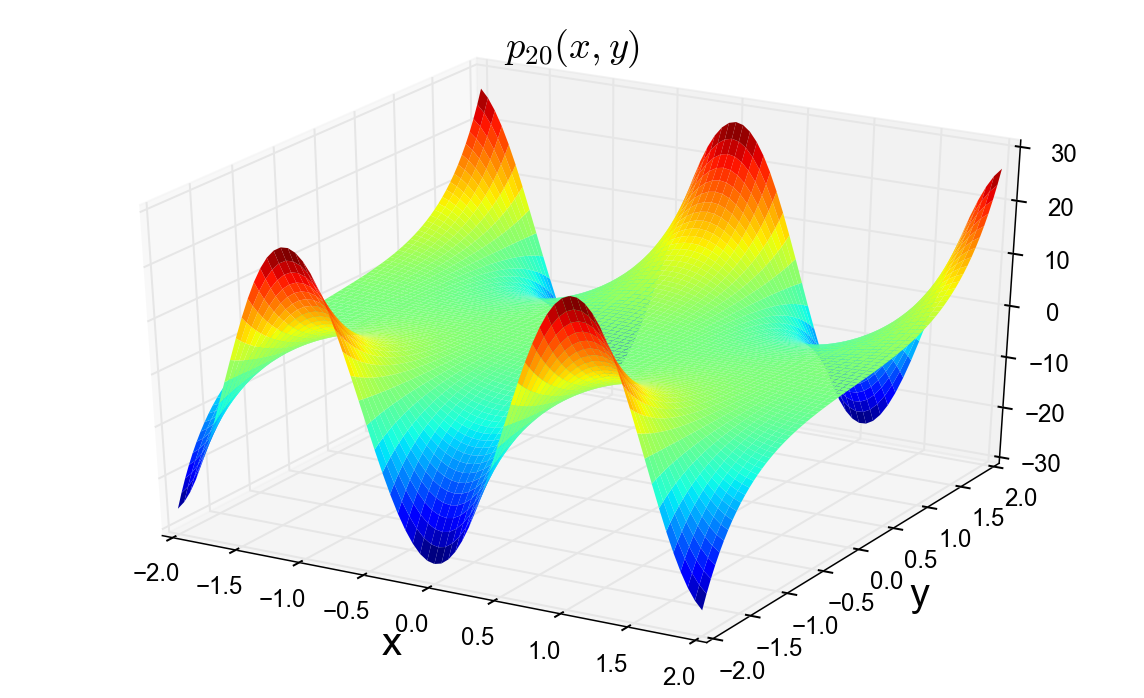

In [24]:
fig = figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, p20, rstride=1, cstride=1, linewidth=0, cmap=cm.jet)
ax.set_xlabel('x')
ax.set_ylabel('y')
title('$p_{20}(x,y)$')

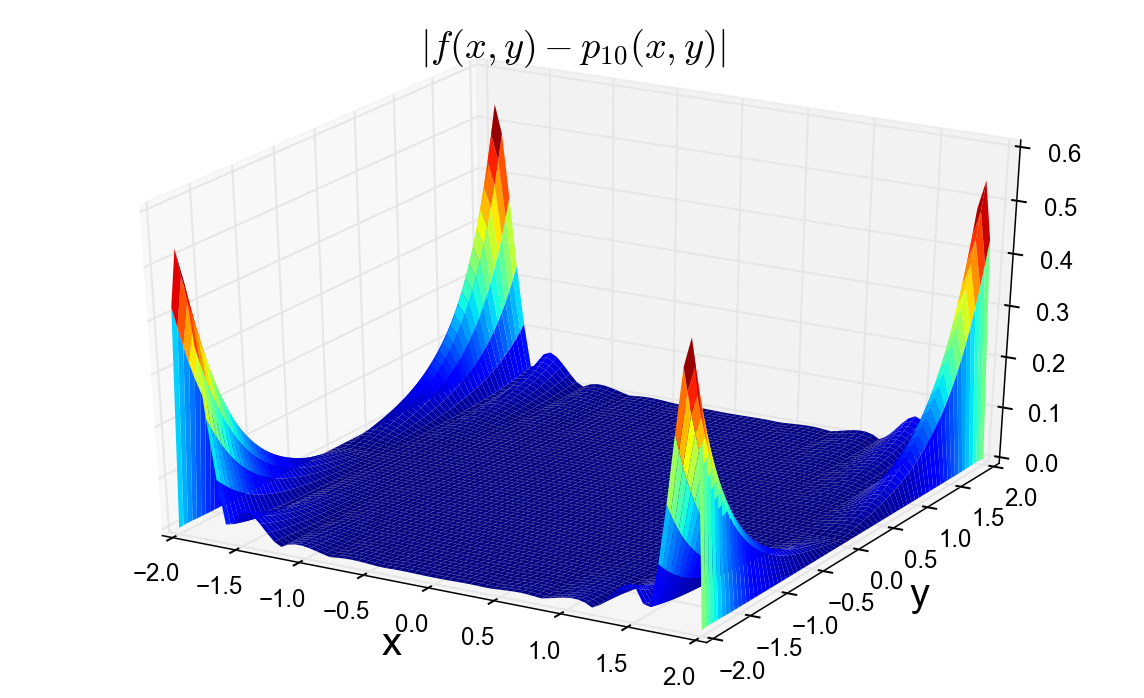

In [25]:
e10 = abs(f-p10)
fig = figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, e10, rstride=1, cstride=1, linewidth=0, cmap=cm.jet)
ax.set_xlabel('x')
ax.set_ylabel('y')
title('$|f(x,y) - p_{10}(x,y)|$')

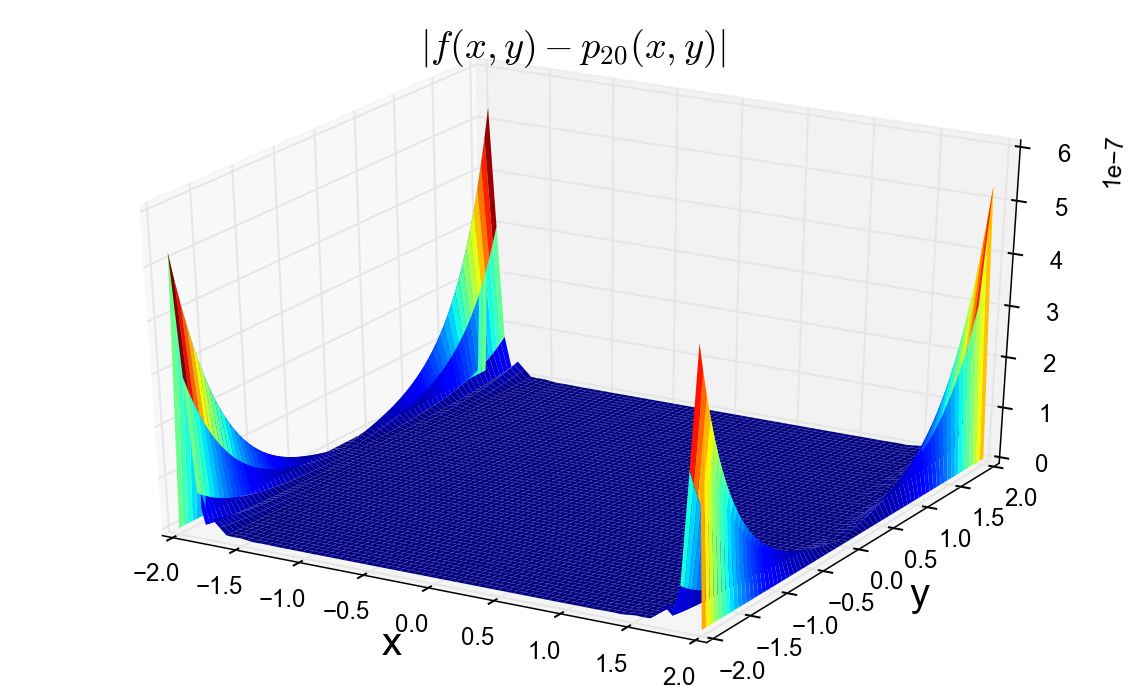

In [26]:
e20 = abs(f-p20)
fig = figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, e20, rstride=1, cstride=1, linewidth=0, cmap=cm.jet)
ax.set_xlabel('x')
ax.set_ylabel('y')
title('$|f(x,y) - p_{20}(x,y)|$')

### Analysis

In [27]:
e10tol = 0.058
e20tol = 3.7e-8
e10norm = sqrt(sum(sum(e10**2))/size(e10))
e20norm = sqrt(sum(sum(e20**2))/size(e20))
if (e10norm > e10tol):
    print('p10 faulure!  ||e10|| = ', e10norm, ' is above tolerance of ',e10tol)
else:
    print('p10 success!  ||e10|| = ', e10norm, ' is below tolerance of ',e10tol)
if (e20norm > e20tol):
    print('p20 failure!  ||e20|| = ', e20norm, ' is above tolerance of ',e20tol)
else:
    print('p20 success!  ||e20|| = ', e20norm, ' is below tolerance of ',e20tol)

p10 success!  ||e10|| =  0.0575277609593  is below tolerance of  0.058
p20 success!  ||e20|| =  3.69171319816e-08  is below tolerance of  3.7e-08


## Part C – 2D Lagrange Interpolation of the 2D Runge function with uniform nodes


### Goals

Using my `Lagrange2D` implementation from the previous section, I had to approximate the 2D Runge function given uniformly-spaced nodes.

### Math Background

#### 2D Runge Function
$$
z = \frac{1}{1+x^2+y^2}
$$

### Implementation Requirements

#### Interpolation

I had to create a file `Runge_uniform.cpp` which performed the following steps for interpolating the 2D Runge function. First, with a mesh `(n,m)` of square size 6, I had to create 7 $x$ nodes and 7 $y$ nodes spanning $[-4,4]$. The `f` matrix represents the function's values on the mesh. After interpolating these nodes with the prior interpolation implementation `Lagrange2D`, I had to evaluate the interpolant over a much finer mesh $(a,b)$ of size $201\times 101$ on the same $[-4,4]$ span. I then had to repeat this entire process but with a node mesh $(n,m)$ of square size 24.

### Implementation

#### Interpolation

Because of the repetitive nature of this and the next part, I put the bulk of the actual interpolation process into a shared file, `Runge_common.cpp`. It is included after the main file, `Runge_uniform.cpp`.

In [28]:
%cat ../src/Runge_uniform.cpp

//
//  Runge_uniform.cpp
//  HPSCProject3
//
//  Created by Paul Herz on 11/1/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#include "Runge_common.cpp"

using namespace PH;

int main() {
	
	std::string prefix = "../data/c/";
	
	// Create an array of 201 evenly-spaced evaluation points `a` over [-4,4].
	// Output this to disk as avals.txt.
	auto a = Vector::linSpace(-4, 4, 201);
	a.saveTo(prefix + "avals.txt");
	
	// Create an array of 101 evenly-spaced evaluation points `b` over [-4,4].
	// Output this to disk as bvals.txt.
	auto b = Vector::linSpace(-4, 4, 101);
	b.saveTo(prefix + "bvals.txt");
	
	// (a) Using n = m = 6, [...]
	int m1 = 6, n1 = 6;
	auto x1 = Vector::linSpace(-4, 4, m1+1);
	auto y1 = Vector::linSpace(-4, 4, n1+1);
	interpolateOverMatrix(6, 6, a, b, x1, y1, prefix + "p6_uni.txt");
	
	// (b) Repeat using n = m = 24, [...]
	int m2 = 24, n2 = 24;
	auto x2 = Vector::linSpace(-4, 4, m2+1);
	auto y2 = Vector::linSpace(-4, 4, n2+1);
	interpolateOverMatrix(24, 24

You can see that this code simply handles creating `a` and `b` for the evaluation mesh (as they only need to be created once for both tests), creating the node mesh $(x,y)$, calling the shared function, then evaluating the true function over the evaluation mesh for presentational and analytic purposes. What follows is `Runge_common.cpp`, which contains the shared `interpolateOverMatrix` function. Its arguments are, in order:
- $m$, the size of the $x$ dimension of the node mesh,
- $n$, the size of the $y$ dimension of the node mesh,
- $a$, the $x$ component of the evaluation mesh,
- $b$, the $y$ component of the evaluation mesh,
- $x$, the $x$ component of the node mesh,
- $y$, the $y$ component of the node mesh,
- and lastly the filename for saving the evaluation of the interpolant over the $(a,b)$ evaluation mesh.

Notice that the creation of the nodes is not done outside of the function - because this component of the interpolation process is repetitive, one simply provides $m$, $n$, $x$, and $y$, and the function generates an $F$ matrix, the 2D matrix of nodes which are input for the interpolant computational process.

In [29]:
%cat ../src/Runge_common.cpp

//
//  Runge_common.cpp
//  HPSCProject3
//
//  Created by Paul Herz on 11/1/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#include <iostream>
#include <cmath>
#include <string>

#include "Vector.h"
#include "Matrix.h"
#include "println.cpp"
#include "Lagrange2D.cpp"

using namespace PH;

double f(double x, double y) {
	// Two dimensional Runge function f(x,y) = (1+x^2+y^2)^-1
	return 1.0/(1+ std::pow(x,2) + std::pow(y,2));
}

void interpolateOverMatrix(int m, int n, const Vector& a, const Vector& b,
						   const Vector& x, const Vector& y, std::string filename) {
	
	// Create a matrix F(m+1, n+1) that contains function values f(x_i, y_j)
	Matrix F(m+1, n+1);
	F.mapElements([&](double& e, size_t i, size_t j){
		e = f(x[i], y[j]);
	});
	
	// Use Lagrange2D to evaluate the polynomial interpolant p(a_i, b_j) at the
	// 201 * 101 evaluation points, storing the results in matrix P(201,101).
	// Output this to disk as p*_uni.txt.
	Matrix P(201, 101);
	P.mapElements([&](doubl

## Part D – 2D Lagrange Interpolation of the 2D Runge function with Chebyshev nodes


### Goals

Repeat the computational process outlined in Part C, wherein the 2D Runge function is approximated by a 2D Lagrange interpolant, but this time, provide a node mesh of Chebyshev nodes rather than a node mesh sourced from simple linear spans.

### Math Background

#### Chebyshev Nodes
A set of $m$ Chebyshev nodes is defined as a set of nodes spanning $[-L,L]$ (for each mesh dimension $1\ldots$)
whose mesh positions are determined not by a linear span function but by the iterative function:
$$
x_i = L \cos\left( \frac{(2i+1)\pi}{2m+2} \right)\ \forall i\in\mathbb{Z} : 0\leq i\leq m
$$

### Implementation
#### Interpolation

Because of the division of concerns for this project and the overall tendency to avoid repetitive code, the implementation of this variation of Part C mainly involved implementing a Chebyshev node span generator - everything else was handled by the common code included above in Part C. The Chebyshev function simply takes the $L$ value and the necessary size $n$, where $n$ in this case is the $m+1$ nodes of a Chebyshev node span. I clarify $m$ to be one less than the node span size, so it can be used for calculation in a basic Vector iteration function. 

In [30]:
%cat ../src/Runge_Chebyshev.cpp

//
//  Runge_Chebyshev.cpp
//  HPSCProject3
//
//  Created by Paul Herz on 11/1/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#include "Runge_common.cpp"

using namespace PH;

Vector chebyshevNodes(double L, size_t n) {
	Vector nodes(n);
	size_t m = n-1; // assuming m+1 nodes
	nodes.mapElements([&](double& x_i, size_t i) {
		x_i = L * std::cos( (2*i+1)*M_PI/(2*m+2) );
	});
	return nodes;
}

int main() {
	
	std::string prefix = "../data/d/";
	
	// Create an array of 201 evenly-spaced evaluation points `a` over [-4,4].
	auto a = Vector::linSpace(-4, 4, 201);
	
	// Create an array of 101 evenly-spaced evaluation points `b` over [-4,4].
	auto b = Vector::linSpace(-4, 4, 101);
	
	// Repeat (a) and (b) from #3 where now `x` and `y` are Chebyshev nodes
	// over [-4,4]:
	
	// (a) Using n = m = 6, [...]
	int m1 = 6, n1 = 6;
	auto x1 = chebyshevNodes(4, m1+1);
	auto y1 = chebyshevNodes(4, n1+1);
	interpolateOverMatrix(6, 6, a, b, x1, y1, prefix + "p6_Cheb.txt");

	// (b) Repeat us

## Graphs for Parts C and D
The following graphs are reproduced for the convenience of the reader, and to accomodate the requirement that graphs appear in a file called `Runge2D` while still allowing for the appropriate consolidation of the analysis into this present document. You may find the graphs in isolated format in the accompanying `Runge2D` report file.

In [32]:
pre_c = '../data/c'
pre_d = '../data/d'
v = {}

v['a'] = pylab.linspace(-4,4,201)
v['b'] = pylab.linspace(-4,4,101)

v['runge'] = loadtxt(pre_c+'/Runge.txt')
v['p6_uni'] = loadtxt(pre_c+'/p6_uni.txt')
v['p24_uni'] = loadtxt(pre_c+'/p24_uni.txt')
v['p6_cheb'] = loadtxt(pre_d+'/p6_Cheb.txt')
v['p24_cheb'] = loadtxt(pre_d+'/p24_Cheb.txt')

In [33]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt

def plotSurfaceOnMesh(surface, xVector, yVector, graphTitle='Untitled', labelX='x', labelY='y'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X,Y = meshgrid(xVector, yVector)
    ax.plot_surface(X, Y, surface, rstride=1, cstride=1, linewidth=0, cmap=cm.jet, antialiased=False)
    ax.set_xlabel(labelX)
    ax.set_ylabel(labelY)
    ax.set_title(graphTitle)

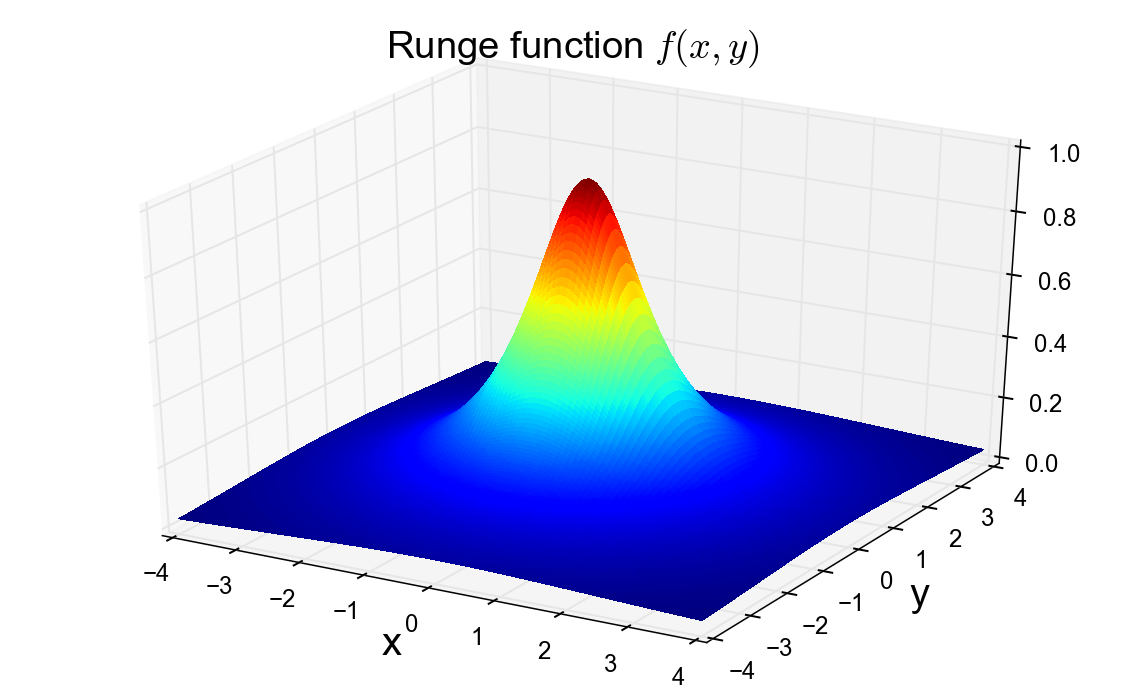

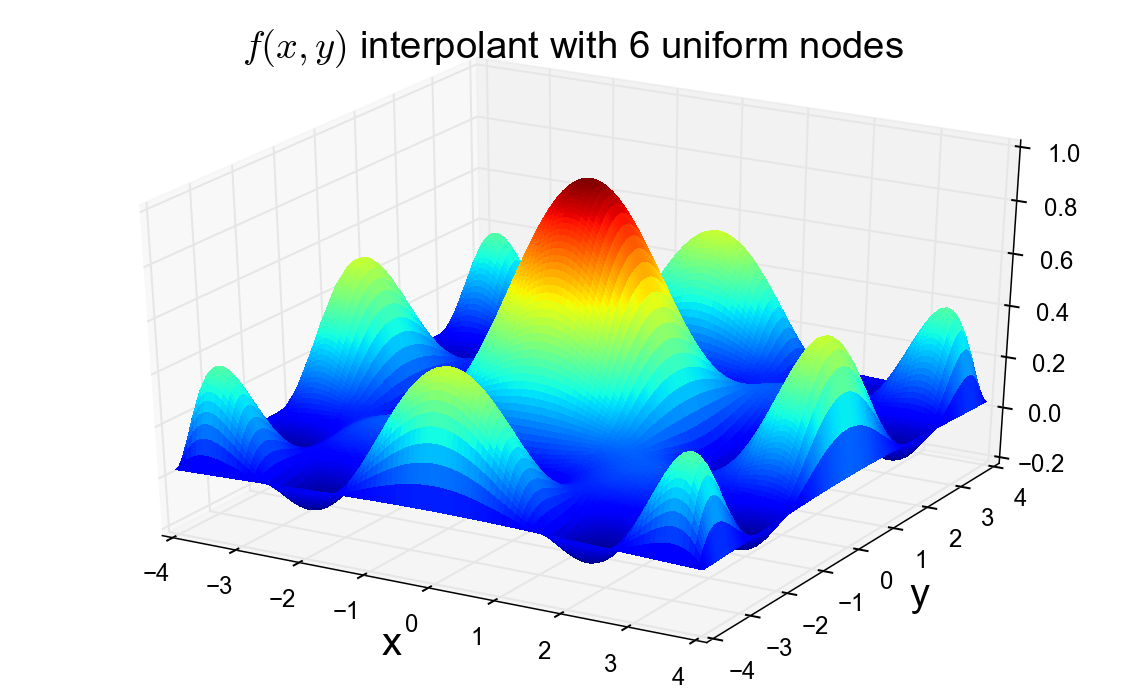

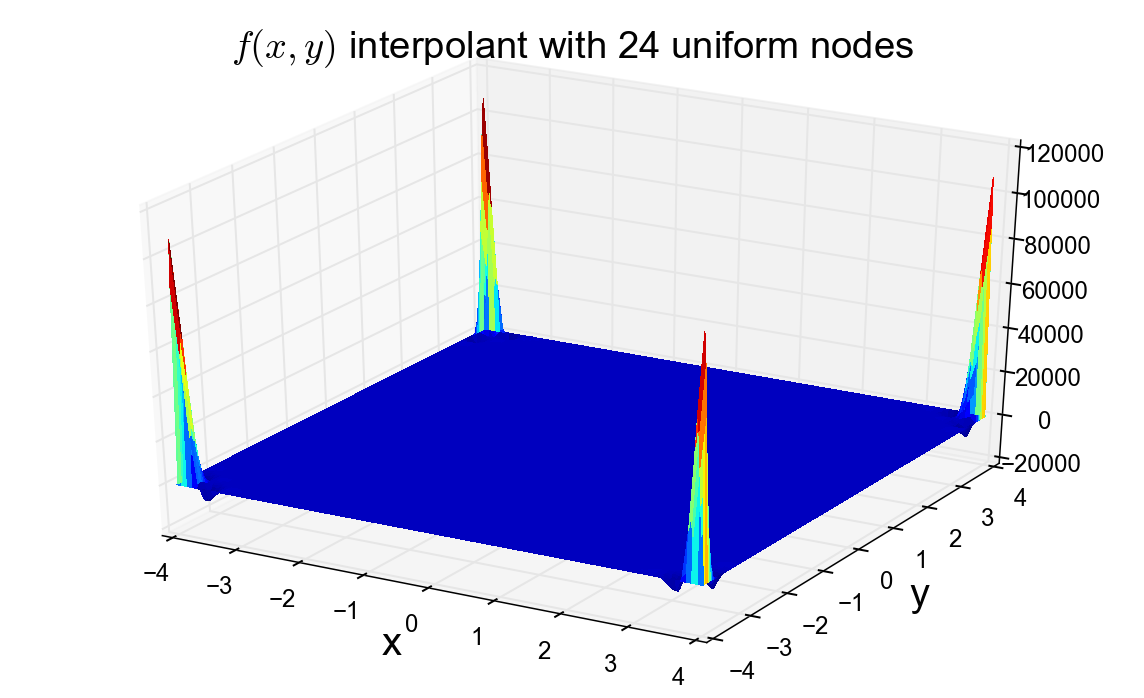

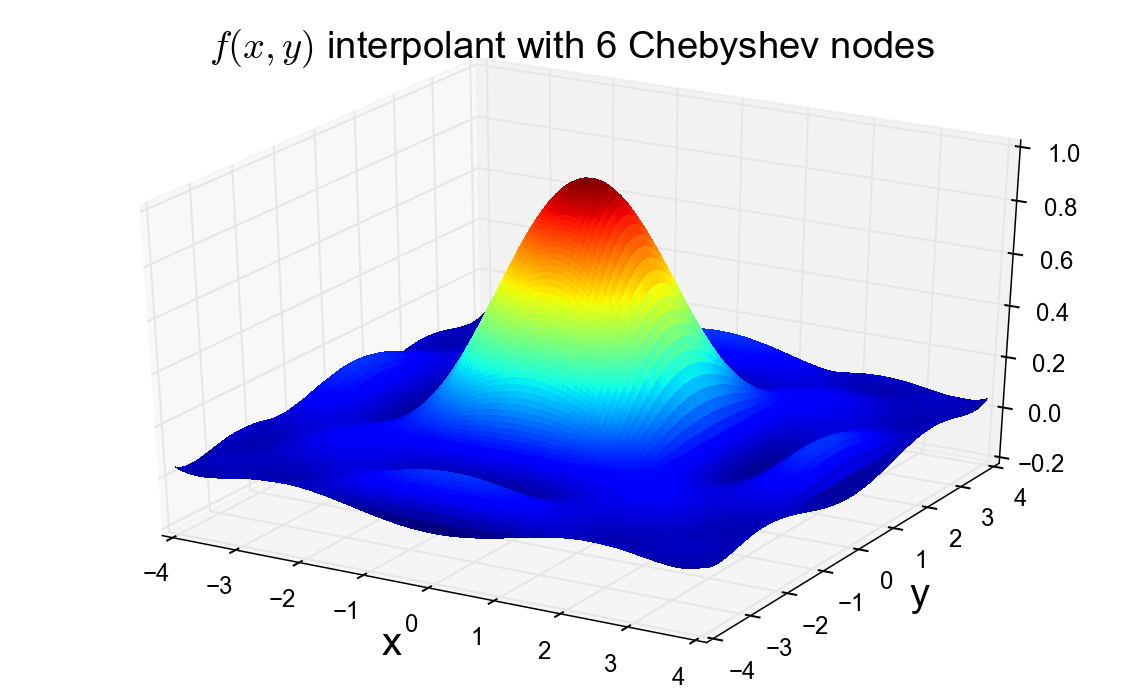

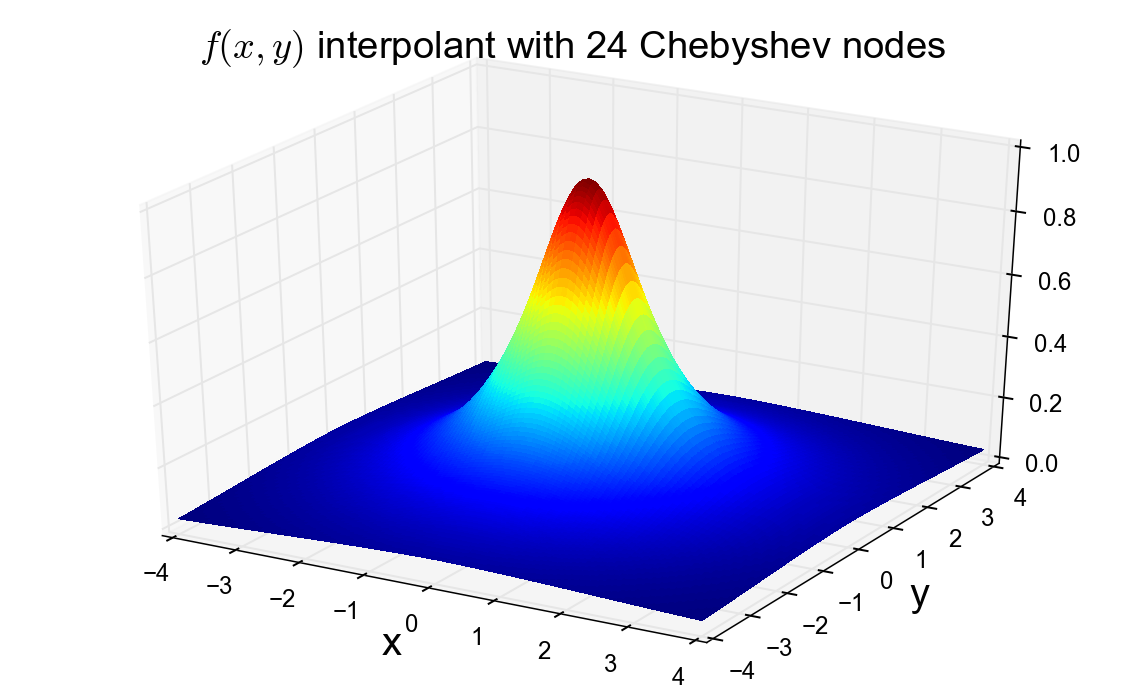

In [40]:
plotSurfaceOnMesh(surface=v['runge'], xVector=v['b'], yVector=v['a'], 
                  graphTitle='Runge function $f(x,y)$')

plotSurfaceOnMesh(surface=v['p6_uni'], xVector=v['b'], yVector=v['a'], 
                  graphTitle='$f(x,y)$ interpolant with 6 uniform nodes')

plotSurfaceOnMesh(surface=v['p24_uni'], xVector=v['b'], yVector=v['a'], 
                  graphTitle='$f(x,y)$ interpolant with 24 uniform nodes')

plotSurfaceOnMesh(surface=v['p6_cheb'], xVector=v['b'], yVector=v['a'], 
                  graphTitle='$f(x,y)$ interpolant with 6 Chebyshev nodes')

plotSurfaceOnMesh(surface=v['p24_cheb'], xVector=v['b'], yVector=v['a'], 
                  graphTitle='$f(x,y)$ interpolant with 24 Chebyshev nodes')

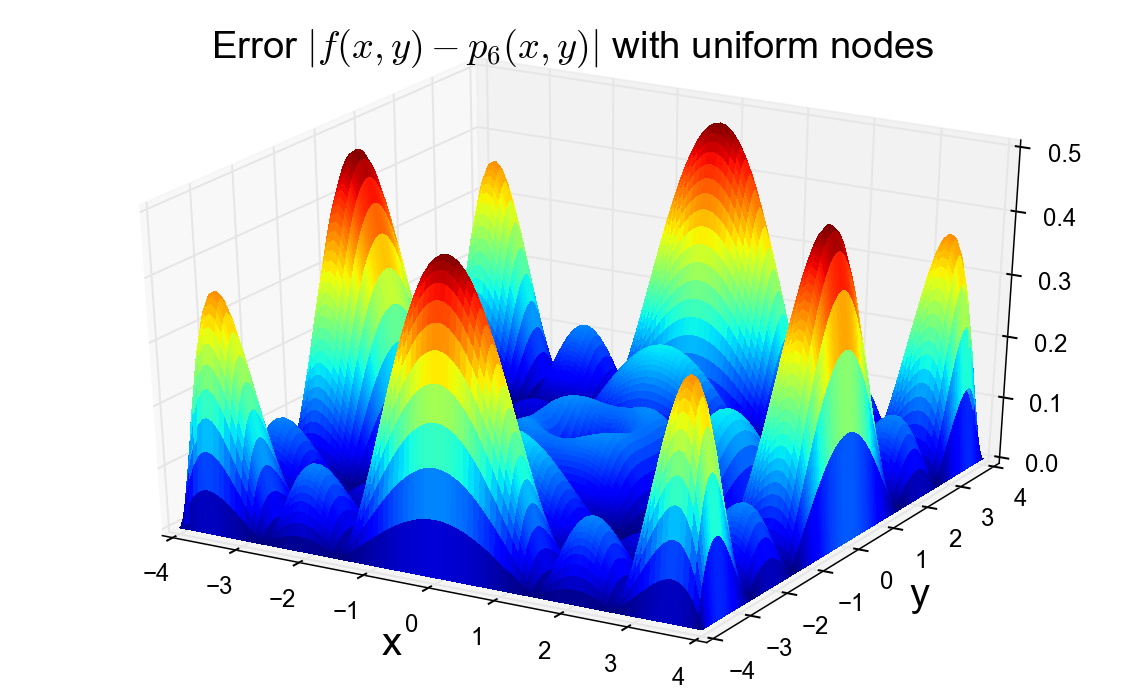

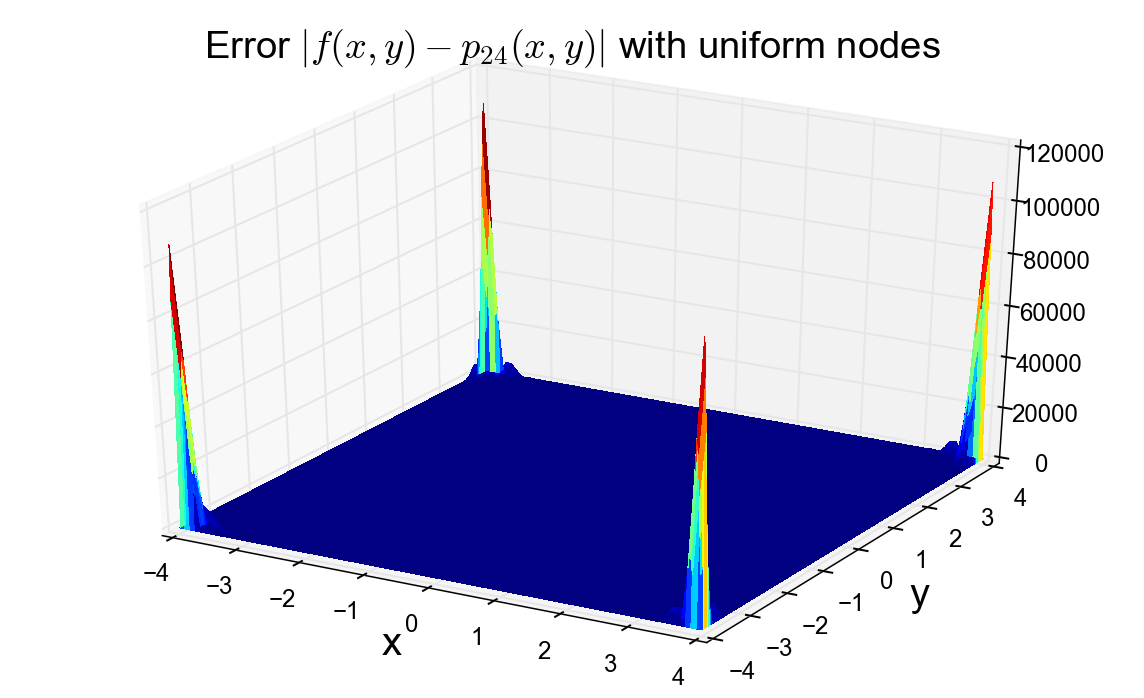

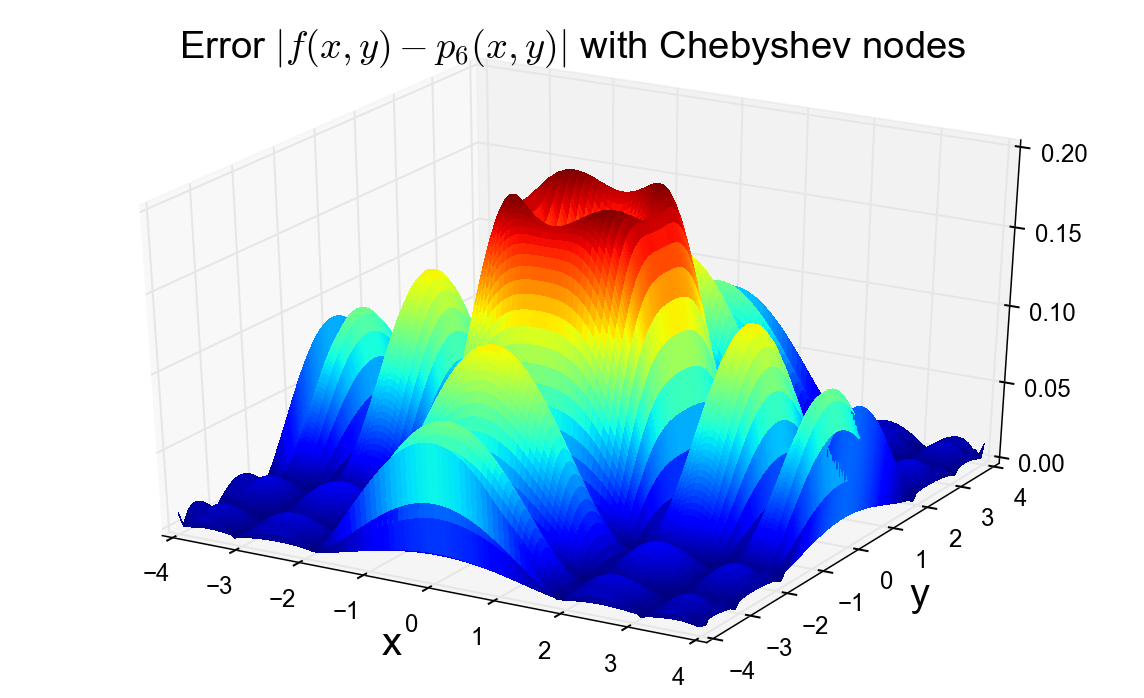

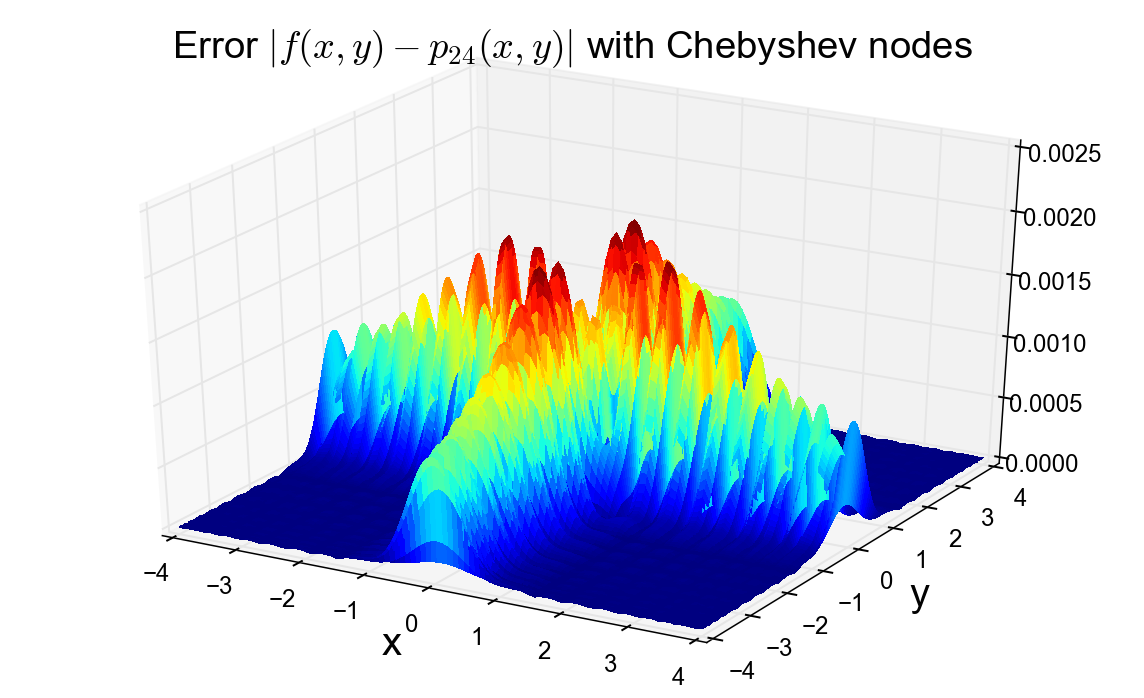

In [39]:
for name in ['p6_uni', 'p24_uni', 'p6_cheb', 'p24_cheb']:
    v['err_'+name] = absolute(v['runge'] - v[name])
plotSurfaceOnMesh(surface=v['err_p6_uni'], xVector=v['b'], yVector=v['a'], 
                  graphTitle='Error $|f(x,y)-p_6(x,y)|$ with uniform nodes')
plotSurfaceOnMesh(surface=v['err_p24_uni'], xVector=v['b'], yVector=v['a'], 
                  graphTitle='Error $|f(x,y)-p_{24}(x,y)|$ with uniform nodes')
plotSurfaceOnMesh(surface=v['err_p6_cheb'], xVector=v['b'], yVector=v['a'], 
                  graphTitle='Error $|f(x,y)-p_6(x,y)|$ with Chebyshev nodes')
plotSurfaceOnMesh(surface=v['err_p24_cheb'], xVector=v['b'], yVector=v['a'], 
                  graphTitle='Error $|f(x,y)-p_{24}(x,y)|$ with Chebyshev nodes')

### Analysis

These graphs are wonderfully descriptive of the performance of their underlying methodologies. The very "lumpy" Uniform 6x6 node interpolant resembles the overall shape of the Runge function, but with the addition of large "bumps," the oscillation further away from the midpoint that is known as Runge's phenomenon, of which the interpolation of the Runge function is a pathological example. Specifically, interpolating the Runge function creates this problem, Runge's phenomenon, only when the source nodes are uniformly spaced. 

When we move to a 24x24 node mesh and 24x24 nodes, we see a runaway and absurd illustration of Runge's phenomenon as the edges of the evaluation mesh oscillate so greatly that the characteristic central rise of the true Runge function is invisible compared to the graphed range.

Looking at the error graphs, we see which "bumps" are the result of Runge's phenomenon in the $p_6$ uniform interpolant, and how they increase towards the edges of the graph. In the $p_24$ error graph, we cannot discern the shape from the interpolant graph due to the overwhelming presence of error.

Moving on to Part D's Chebyshev nodes, a nonlinear span of nodes which mitigates the Runge phenomenon, we see a very acceptable interpolation of the true function, whose central feature resembles in slope the uniform $p_6$ interpolant, but with much less pronounced oscillatory error away from the midpoint. Perhaps most importantly, when we increase the node mesh to 24x24, we do not see a runaway takeover of Runge's phenomenon, but in fact a vast improvement in the quality of the interpolant, now almost perfectly for our purposes approximating the true function. 

Thus it is very clear that Runge's phenomenon, as is known, is confined to manifest pathologically in only interpolants sourced from a linear node span. Moreover, it is empirically evident that Runge's phenomenon becomes far more pronounced in interpolants of uniform node span when the span size (number of nodes) is increased. Inversely, when using a nonlinear node span (here, Chebyshev), it is empirically evident that the quality of the interpolant and the reduction of peripheral oscillatory error only **decreases** as the size of the span (number of nodes) increases.

One easy to ignore feature of the Chebyshev node based interpolants becomes apparent in the error graphs through visual observation - a very clear cross pattern that becomes more striking as node count increases. It appears that when $x\approx 0$ or $y\approx 0$ there is a marked increase in error, even in the visibly ideal Chebyshev $p_{24}$ interpolant when looking at the interpolant graph. This is because around zero, the 2D Runge function begins to behave like the 1D Runge function, exposing in some way greater error, perhaps because Chebyshev nodes input to a 2D interpolation algorithm do not mitigate  Runge's phenomenon on a 2D mesh as the function's behaviour approximates that of the 1D Runge function. The means of action for this issue are not known to me. But for illustrative purposes, I've included a cross section of the Chebyshev node $p_{24}$ graph at $x=0$.

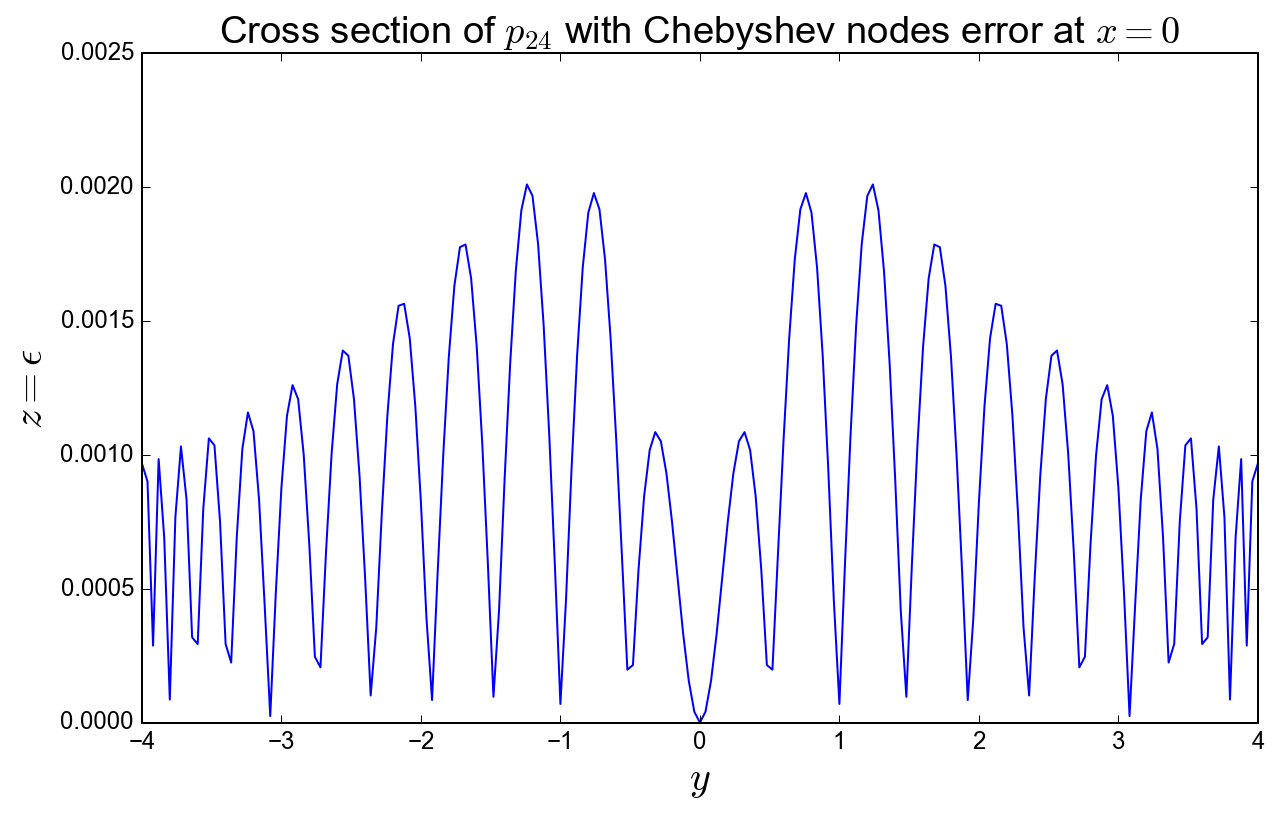

In [56]:
zeroIndex = numpy.where(v['b'] == 0)[0]
crossSection = v['err_p24_cheb'][:, zeroIndex]
plot(v['a'], crossSection)
title('Cross section of $p_{24}$ with Chebyshev nodes error at $x=0$')
xlabel('$y$')
ylabel('$z=\epsilon$')